## Imports

In [1]:
# Imports
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

# Settings
np.set_printoptions(linewidth=200)
print("TensorFlow Version: ", tf.__version__)

TensorFlow Version:  2.3.0


## Data Preprocessing

In [9]:
# Extract the contents of the zipped file
local_zip = './data/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./data/cats_and_dogs_filtered')
zip_ref.close()

In [2]:
# Assigning Directories
training_cats = os.path.join('./data/cats_and_dogs_filtered/train/cats')
training_dogs = os.path.join('./data/cats_and_dogs_filtered/train/dogs')
validation_cats = os.path.join('./data/cats_and_dogs_filtered/validation/cats')
validation_dogs = os.path.join('./data/cats_and_dogs_filtered/validation/dogs')

In [3]:
print('Total training cat images :', len(os.listdir(training_cats)))
print('Total training dog images :', len(os.listdir(training_dogs)))

print('Total validation cat images :', len(os.listdir(validation_cats)))
print('Total validation dog images :', len(os.listdir(validation_dogs)))

Total training cat images : 1000
Total training dog images : 1000
Total validation cat images : 500
Total validation dog images : 500


In [4]:
# Checking File Names
print("Cat Image Names: ", os.listdir(training_cats)[:5], os.listdir(validation_cats)[:5])
print("Dog Image Names: ", os.listdir(training_dogs)[:5], os.listdir(validation_dogs)[:5])

Cat Image Names:  ['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.101.jpg'] ['cat.2000.jpg', 'cat.2001.jpg', 'cat.2002.jpg', 'cat.2003.jpg', 'cat.2004.jpg']
Dog Image Names:  ['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg'] ['dog.2000.jpg', 'dog.2001.jpg', 'dog.2002.jpg', 'dog.2003.jpg', 'dog.2004.jpg']


In [5]:
# Initialising Image Preview
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

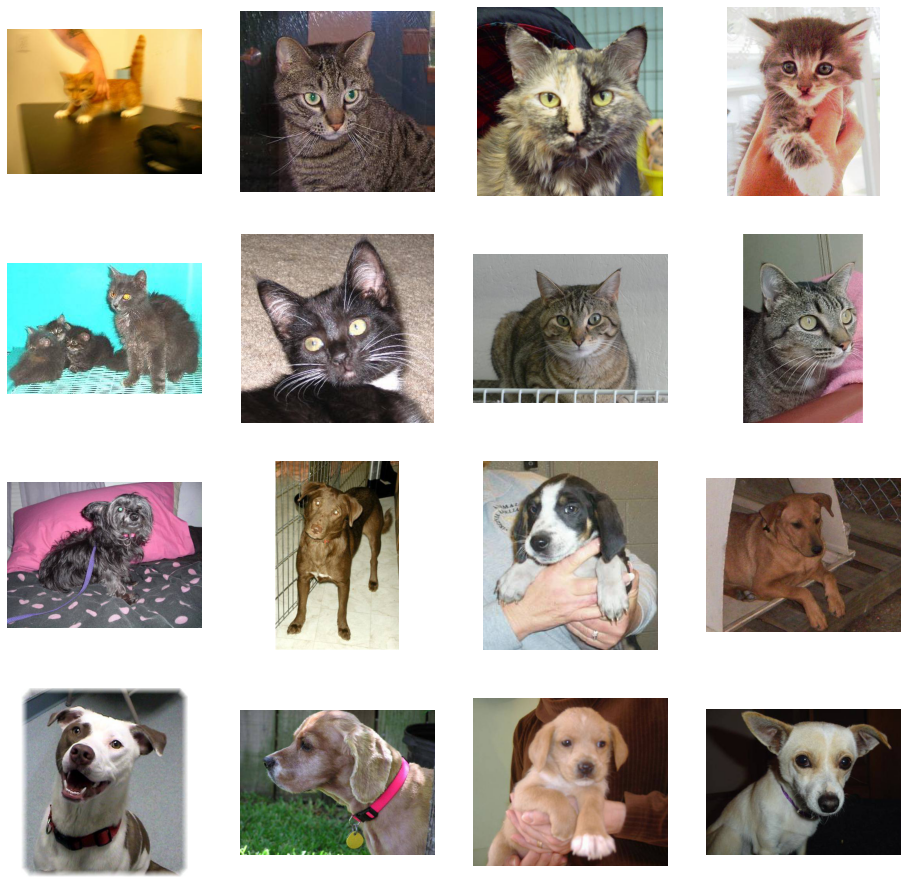

In [6]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_happy_pix = [os.path.join(training_cats, fname) 
                for fname in os.listdir(training_cats)[pic_index-8:pic_index]]
next_sad_pix = [os.path.join(training_dogs, fname) 
                for fname in os.listdir(training_dogs)[pic_index-8:pic_index]]

for i, img_path in enumerate(next_happy_pix + next_sad_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


## Image Data Generator

In [7]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        './data/cats_and_dogs_filtered/train/',  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        class_mode='binary'
)

Found 2000 images belonging to 2 classes.


In [8]:
# All images will be rescaled by 1./255
validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 20 using train_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        './data/cats_and_dogs_filtered/validation/',  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        class_mode='binary'
)

Found 1000 images belonging to 2 classes.


## Callbacks

In [9]:
class accuracyLimit(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('loss') < 0.01):
            print("\n----------Reached Accuracy Limit----------")
            self.model.stop_training = True
accuracyCallback = accuracyLimit()

## Setting up Model

In [10]:
# Model Definition
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

In [12]:
model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.001), metrics=['accuracy'])

In [13]:
history = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch=100, epochs=15, verbose=2, validation_steps=50, callbacks=[accuracyCallback])

Epoch 1/15
100/100 - 31s - loss: 0.7836 - accuracy: 0.5620 - val_loss: 0.6360 - val_accuracy: 0.6640
Epoch 2/15
100/100 - 28s - loss: 0.6239 - accuracy: 0.6695 - val_loss: 0.5882 - val_accuracy: 0.6850
Epoch 3/15
100/100 - 28s - loss: 0.5396 - accuracy: 0.7325 - val_loss: 0.5676 - val_accuracy: 0.7300
Epoch 4/15
100/100 - 29s - loss: 0.4748 - accuracy: 0.7660 - val_loss: 0.7094 - val_accuracy: 0.6530
Epoch 5/15
100/100 - 27s - loss: 0.3967 - accuracy: 0.8175 - val_loss: 0.5747 - val_accuracy: 0.7160
Epoch 6/15
100/100 - 27s - loss: 0.3082 - accuracy: 0.8675 - val_loss: 0.6100 - val_accuracy: 0.7290
Epoch 7/15
100/100 - 28s - loss: 0.2254 - accuracy: 0.9085 - val_loss: 0.7422 - val_accuracy: 0.7190
Epoch 8/15
100/100 - 29s - loss: 0.1490 - accuracy: 0.9430 - val_loss: 0.9361 - val_accuracy: 0.6860
Epoch 9/15
100/100 - 28s - loss: 0.1121 - accuracy: 0.9575 - val_loss: 0.8834 - val_accuracy: 0.7180
Epoch 10/15
100/100 - 33s - loss: 0.0790 - accuracy: 0.9745 - val_loss: 1.0158 - val_accura

## Visualising Intermediate Representations

C:\Users\320035675\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


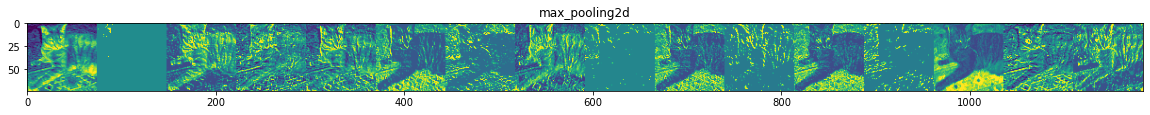

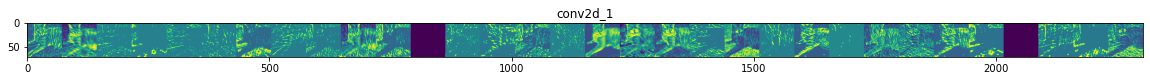

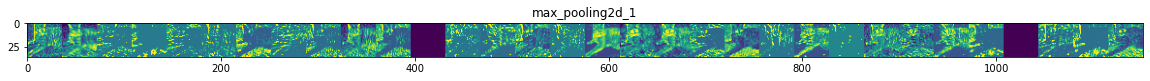

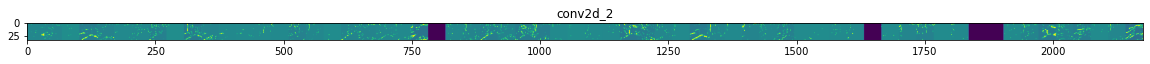

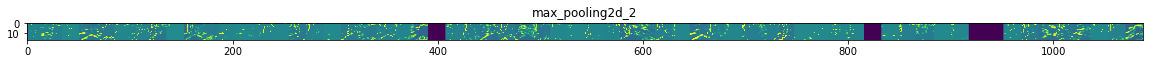

In [14]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
# Let's prepare a random input image from the training set.
cat_img_files = [os.path.join(training_cats, f) for f in os.listdir(training_cats)]
dog_img_files = [os.path.join(training_dogs, f) for f in os.listdir(training_dogs)]
img_path = random.choice(cat_img_files + dog_img_files)

img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers[1:]]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

Text(0.5, 1.0, 'Training and validation loss')

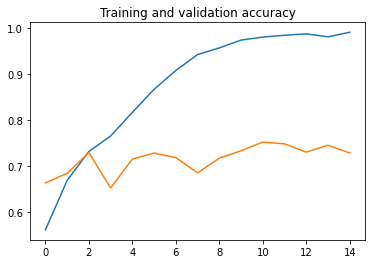

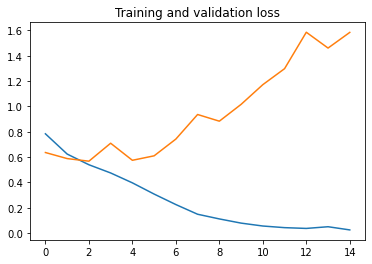

In [15]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs, acc)
plt.plot  ( epochs, val_acc)
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs, loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss')

## Predictions

In [21]:
import numpy as np
from keras.preprocessing import image

path = os.path.join('./data/validation/dog1.jpg')

img = image.load_img(path, target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
print(classes)
if classes[0]>0.5:
    print("This is a cat")
else:
    print("This is a dog")

[[1.]]
This is a cat
